In [1]:
import numpy  as np
import sympy  as sym
import psydac as ps

import matplotlib.pyplot as plt
import scipy.sparse      as sparse

from psydac.linalg.iterative_solvers import cg
from psydac.fem.basic                import FemField
from psydac.linalg.stencil           import StencilMatrix, StencilVector, StencilVectorSpace
from psydac.linalg.block             import ProductSpace, BlockVector, BlockLinearOperator, BlockMatrix

import utilitis_FEEC.evaluation as eva
import utilitis_FEEC.bsplines   as bsp

import utilitis_FEEC.mass_matrices_stencil as mass_sten
import utilitis_FEEC.mass_matrices_curved  as mass_curv
import utilitis_FEEC.integrate             as mass_slab

In [20]:
# ... define boundary conditions in each direction (True: periodic, False: else)
bc = [False, True, True]
bc_1, bc_2, bc_3 = bc


# ... number of elements and element boundaries in each direction
Nel_1 = 64
Nel_2 = 128
Nel_3 = 2

el_b_1 = np.linspace(0., 1., Nel_1 + 1)
el_b_2 = np.linspace(0., 1., Nel_2 + 1)
el_b_3 = np.linspace(0., 1., Nel_3 + 1)

# ... degree of spline basis (of the 0-forms) in each direction
p = [2, 2, 2]
p1, p2, p3 = p


# ... geometry
mapping = 'torus'


# ... number of basis functions
Nbase = [Nel_1 + p1, Nel_2 + p2, Nel_3 + p3] 
Nbase_1, Nbase_2, Nbase_3 = Nbase


# ... knot vectors
T1 = bsp.make_knots(el_b_1, p1, bc_1)
T2 = bsp.make_knots(el_b_2, p2, bc_2)
T3 = bsp.make_knots(el_b_3, p3, bc_3)    
T = [T1, T2, T3]



# ... define physical domain and mapping from logical domain
if mapping == 'annulus':
    
    # ... coordinates
    r, phi, z = sym.symbols('r, phi, z')
    q = sym.Matrix([r, phi, z])
    
    # ... mapping
    R1 = 0.2         # inner radius
    R2 = 1.0         # outer radius
    dR = R2 - R1     # thickness
    
    F = sym.Matrix([(r*dR + R1)*sym.cos(2*sym.pi*phi), (r*dR + R1)*sym.sin(2*sym.pi*phi), z])
    
elif mapping == 'torus':
    
    # ... coordinates
    r, theta, phi = sym.symbols('r, theta, phi')
    q = sym.Matrix([r, theta, phi])

    # ... mapping
    R0 = 1.5         # major radius
    R1 = 0.2         # inner radius
    R2 = 1.0         # outer radius
    dR = R2 - R1     # thickness
    
    F = sym.Matrix([(R0 + (r*dR + R1)*sym.cos(2*sym.pi*theta))*sym.cos(2*sym.pi*phi), (R0 + (r*dR + R1)*sym.cos(2*sym.pi*theta))*sym.sin(2*sym.pi*phi), (r*dR + R1)*sym.sin(2*sym.pi*theta)])
    
elif mapping == 'cube':
    
    # ... coordinates
    x, y, z = sym.symbols('x, y, z')
    q = sym.Matrix([x, y, z])
    
    # ... mapping
    Lx = 1.           # length in x
    Ly = 1.           # length in y
    Lz = 1.           # length in z
    
    F = sym.Matrix([Lx*x, Ly*y, Lz*z])
    

# ... jacobian matrix
DF = F.jacobian(q)

# ... metric tensor
G = sym.simplify(DF.transpose()*DF)

# ... inverse of metric tensor
Ginv = G.inverse()

#... square root of jacobi determinant
g = sym.simplify(G.det())
g_sqrt = sym.sqrt(g)


# ... convert mapping functions to callables
xc = sym.lambdify(q, F[0])
yc = sym.lambdify(q, F[1])
zc = sym.lambdify(q, F[2])

G = [[sym.lambdify(q, G[0, 0]), sym.lambdify(q, G[0, 1]), sym.lambdify(q, G[0, 2])], [sym.lambdify(q, G[1, 0]), sym.lambdify(q, G[1, 1]), sym.lambdify(q, G[1, 2])], [sym.lambdify(q, G[2, 0]), sym.lambdify(q, G[2, 1]), sym.lambdify(q, G[2, 2])]]
Ginv = [[sym.lambdify(q, Ginv[0, 0]), sym.lambdify(q, Ginv[0, 1]), sym.lambdify(q, Ginv[0, 2])], [sym.lambdify(q, Ginv[1, 0]), sym.lambdify(q, Ginv[1, 1]), sym.lambdify(q, Ginv[1, 2])], [sym.lambdify(q, Ginv[2, 0]), sym.lambdify(q, Ginv[2, 1]), sym.lambdify(q, Ginv[2, 2])]]
g = sym.lambdify(q, g)
g_sqrt = sym.lambdify(q, g_sqrt)

In [2]:
test = np.random.rand(9)

In [7]:
test2 = np.empty((3, 3), order='F')

In [8]:
test2[:, :] = np.reshape(test, (3, 3))

In [6]:
test2

array([[0.5573329 , 0.67314825, 0.71991357],
       [0.24588113, 0.70486866, 0.38268133],
       [0.749976  , 0.93179799, 0.90313161]])

In [9]:
test2

array([[0.5573329 , 0.67314825, 0.71991357],
       [0.24588113, 0.70486866, 0.38268133],
       [0.749976  , 0.93179799, 0.90313161]])

In [3]:
L = 1.5
length = lambda x : L

In [4]:
mass_0 = mass_sten.mass_matrix_V0_1d(p1, Nbase_1, T1, length, bc_1)
Mass_0 = mass_slab.mass_matrix_V0_1d(p1, Nbase_1, T1*L, None)

In [5]:
np.allclose(mass_0.toarray(), Mass_0)

True

In [6]:
mass_1 = mass_sten.mass_matrix_V1_1d(p1, Nbase_1, T1, length, bc_1)
Mass_1 = mass_slab.mass_matrix_V1_1d(p1, Nbase_1, T1*L, None)

In [7]:
np.allclose(mass_1.toarray(), Mass_1)

True

In [21]:
mass_0 = mass_sten.mass_matrix_V0(p, Nbase, T, g_sqrt, bc)
#Mass_0 = mass_curv.mass_matrix_V0(p, Nbase, T, g_sqrt, [None, None, None])

In [18]:
np.allclose(mass_0.toarray(), Mass_0.toarray())

True

In [22]:
# ... component of 0-form to be projected
a = lambda r, theta, phi : r*np.sin(2*np.pi*r)*np.sin(4*np.pi*theta)

In [23]:
f0 = mass_sten.inner_prod_V0(a, p, Nbase, T, g_sqrt, bc)
#F0 = mass_curv.L2_prod_V0(a, p, Nbase, T, g_sqrt, [None, None, None])

In [13]:
np.allclose(f0.toarray(), F0)

NameError: name 'F0' is not defined

In [14]:
a_vec = sparse.linalg.spsolve(mass_0.tosparse().tocsc(), f0.toarray())

In [24]:
m0 = mass_0.tosparse().tocsc()

In [25]:
test = sparse.linalg.splu(m0)

In [30]:
test = np.sqrt(mass_sten.L2_error_V0(test.solve(f0.toarray()), a, p, Nbase, T, g_sqrt, bc))

In [31]:
test

1.1956631706855405e-05

In [25]:
mass_1, V1 = mass_sten.mass_matrix_V1(p, Nbase, T, Ginv, g_sqrt, bc)
Mass_1 = mass_curv.mass_matrix_V1(p, Nbase, T, Ginv, g_sqrt, [True, True, True])

In [26]:
mass_1 = BlockMatrix(V1, V1, blocks=mass_1)

In [27]:
np.allclose(mass_1.toarray(), Mass_1.toarray())

True

In [34]:
# ... components of 1-form to be projected
a_bold = [lambda r, theta, phi : r*np.sin(2*np.pi*r)*np.sin(4*np.pi*theta), lambda r, theta, phi : r**2*np.sin(2*np.pi*r)*np.sin(4*np.pi*theta), lambda r, theta, phi : r**3*np.sin(2*np.pi*r)*np.sin(4*np.pi*theta)]

In [39]:
f1, V1 = mass_sten.inner_prod_V1(a_bold, p, Nbase, T, Ginv, g_sqrt, bc)
F1 = mass_curv.L2_prod_V1(a_bold, p, Nbase, T, Ginv, g_sqrt, [None, None, None])

In [40]:
f1 = BlockVector(V1, blocks=f1)

In [41]:
np.allclose(f1.toarray(), F1)

True

In [17]:
mass_2, V2 = mass_sten.mass_matrix_V2(p, Nbase, T, G, g_sqrt, bc)
Mass_2 = mass_curv.mass_matrix_V2(p, Nbase, T, G, g_sqrt, [True, True, True])

In [18]:
mass_2 = BlockMatrix(V2, V2, blocks=mass_2)

In [19]:
np.allclose(mass_2.toarray(), Mass_2.toarray())

True

In [20]:
# ... components of 2-form to be projected
a_hat = [lambda r, theta, phi : r*np.sin(2*np.pi*r)*np.sin(4*np.pi*theta), lambda r, theta, phi : r**2*np.sin(2*np.pi*r)*np.sin(4*np.pi*theta), lambda r, theta, phi : r**3*np.sin(2*np.pi*r)*np.sin(4*np.pi*theta)]

In [21]:
f2, V2 = mass_sten.inner_prod_V2(a_hat, p, Nbase, T, G, g_sqrt, bc)
F2 = mass_curv.L2_prod_V2(a_hat, p, Nbase, T, G, g_sqrt, [True, True, True])

In [22]:
f2 = BlockVector(V2, blocks=f2)

In [23]:
np.allclose(f2.toarray(), F2)

True

In [10]:
mass_3 = mass_sten.mass_matrix_V3(p, Nbase, T, g_sqrt, bc)
Mass_3 = mass_curv.mass_matrix_V3(p, Nbase, T, g_sqrt, [None, None, None])

In [11]:
np.allclose(mass_3.toarray(), Mass_3.toarray())

True

In [18]:
# ... component of 3-form to be projected
a123 = lambda r, theta, phi : r*np.sin(2*np.pi*r)*np.sin(4*np.pi*theta)

In [19]:
f3 = mass_sten.inner_prod_V3(a123, p, Nbase, T, g_sqrt, bc)
F3 = mass_curv.L2_prod_V3(a123, p, Nbase, T, g_sqrt, [None, None, None])

In [20]:
np.allclose(f3.toarray(), F3)

True

In [23]:
# ... component of 0-form to be projected
a = lambda r, theta, phi : r*np.sin(2*np.pi*r)*np.sin(4*np.pi*theta)

In [17]:
# ... mass matrix in V0
import time

timea = time.time()
M0 = mass_op.mass_matrix_V0(V, g_sqrt)
timeb = time.time()

print(timeb - timea)

1.8645546436309814


In [20]:
# ... mass matrix in V0
import time

timea = time.time()
M1 = mass_op.mass_matrix_V0(V, g_sqrt)
timeb = time.time()

print(timeb - timea)

1.8452134132385254


In [22]:
M0.toarray()

array([[1.65446366e-04, 6.51758413e-05, 2.50676313e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.51758413e-05, 1.65446366e-04, 6.51758413e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.50676313e-06, 6.51758413e-05, 1.65446366e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.07130632e-03, 4.22029762e-04, 1.62319139e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.22029762e-04, 1.07130632e-03, 4.22029762e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.62319139e-05, 4.22029762e-04, 1.07130632e-03]])

In [23]:
M1.toarray()

array([[ 24981.56483413,   9841.22251042,    378.50855809, ...,
             0.        ,      0.        ,      0.        ],
       [  9841.22251042,  24981.56483413,   9841.22251042, ...,
             0.        ,      0.        ,      0.        ],
       [   378.50855809,   9841.22251042,  24981.56483413, ...,
             0.        ,      0.        ,      0.        ],
       ...,
       [     0.        ,      0.        ,      0.        , ...,
        161761.83763645,  63724.36028103,   2450.93693389],
       [     0.        ,      0.        ,      0.        , ...,
         63724.36028103, 161761.83763645,  63724.36028103],
       [     0.        ,      0.        ,      0.        , ...,
          2450.93693389,  63724.36028103, 161761.83763645]])

In [7]:
# ... L2-scalar product in V0
a_int = mass_op.inner_prod_V0(V, g_sqrt, a)

In [90]:
# ... solve system
a_vec, info = cg(M0, a_int, tol=1e-10, maxiter=100, verbose=False)

In [91]:
# ... create Fem field
a_h = FemField(V, coeffs=a_vec)
a_h.coeffs.update_ghost_regions()

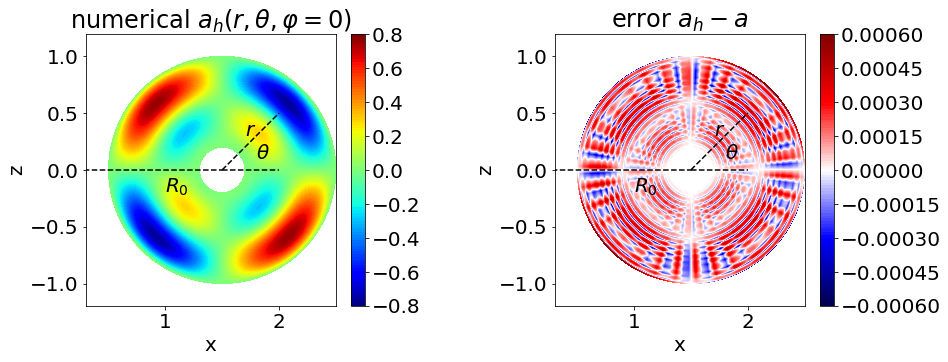

In [93]:
# ... plot analytical and numerical solution
plt.rcParams.update({'font.size': 20})

phiplot = np.array([0.0])

rplot = np.linspace(0., 1., 100)
thetaplot = np.linspace(0., 1., 100)

R, THETA = np.meshgrid(rplot, thetaplot, indexing = 'ij')

A = a(R, THETA, phiplot)

A_h = eva.evaluate_field_V0(a_vec.toarray(), [rplot, thetaplot, phiplot], p, Nbase, T, bc)
A_h = np.reshape(A_h, (100, 100))

X, Z = xc(R, THETA, phiplot), zc(R, THETA, phiplot)

f = plt.figure()
f.set_figwidth(14)
f.set_figheight(5)

plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace=0.5)

plt.contourf(X, Z, A_h, levels=np.linspace(-0.8, 0.8, 100), cmap='jet')
plt.colorbar(ticks = np.linspace(-0.8, 0.8, 9))
plt.axis('equal')
plt.title(r'numerical $a_h(r,\theta,\varphi=0)$')
plt.xlabel('x')
plt.ylabel('z')
plt.plot(np.linspace(0., 1.5, 10), np.zeros(10), 'k--')

xp = np.linspace(1.5, 2.0, 10)
plt.plot(xp, xp - 1.5, 'k--')
plt.plot(xp, np.zeros(10), 'k--')
plt.text(1.8, 0.1, r'$\theta$')
plt.text(1.7, 0.3, r'$r$')

plt.xlim((R0 - 1.2*R2, R0 + R2))
plt.text(1.0, -0.2, '$R_0$')


plt.subplot(1, 2, 2)

plt.contourf(X, Z, A_h - A, levels=np.linspace(-0.0006, 0.0006, 100), cmap='seismic')
plt.colorbar(ticks = np.linspace(-0.0006, 0.0006, 9))
plt.axis('equal')
plt.title(r'error $a_h-a$')
plt.xlabel('x')
plt.ylabel('z')
plt.plot(np.linspace(0., 1.5, 10), np.zeros(10), 'k--')

xp = np.linspace(1.5, 2.0, 10)
plt.plot(xp, xp - 1.5, 'k--')
plt.plot(xp, np.zeros(10), 'k--')
plt.text(1.8, 0.1, r'$\theta$')
plt.text(1.7, 0.3, r'$r$')

plt.xlim((R0 - 1.2*R2, R0 + R2))
plt.text(1.0, -0.2, '$R_0$')

plt.savefig('/home/florian/Desktop/PHD/04_Präsentationen/01_FEEC/01_Figures/0_form.pdf', bbox_inches = 'tight')

## Convergence for radial variation only

In [10]:
# Create 1D finite element spaces
V1 = ps.fem.splines.SplineSpace(px, grid=el_b_x, periodic=False)
V2 = ps.fem.splines.SplineSpace(py, grid=el_b_y, periodic=True)
V3 = ps.fem.splines.SplineSpace(pz, grid=el_b_z, periodic=True)

# Create 3D tensor product finite element space
V = ps.fem.tensor.TensorFemSpace(V1, V2, V3)

In [11]:
# ... component of 0-form to be projected
a = lambda r, theta, phi : r*np.sin(2*np.pi*r)*np.sin(4*np.pi*theta)

# ... mass matrix in V0
M0 = mass_op.mass_matrix_V0(V, g_sqrt)

# ... L2-scalar product in V0
a_int = mass_op.inner_prod_V0(V, g_sqrt, a)

# ... solve system
a_vec, info = cg(M0, a_int, tol=1e-10, maxiter=100, verbose=False)

Text(1,-0.2,'$R_0$')

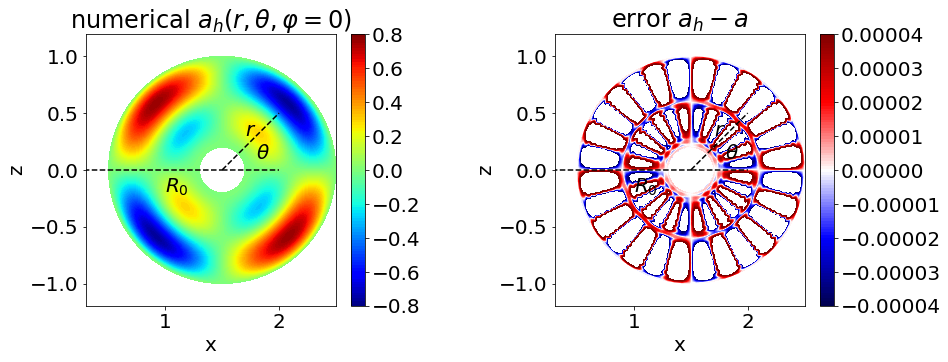

In [12]:
# ... plot analytical and numerical solution
plt.rcParams.update({'font.size': 20})

phiplot = np.array([0.0])

rplot = np.linspace(0., 1., 100)
thetaplot = np.linspace(0., 1., 100)

R, THETA = np.meshgrid(rplot, thetaplot, indexing = 'ij')

A = a(R, THETA, phiplot)

A_h = eva.evaluate_field_V0(a_vec.toarray(), [rplot, thetaplot, phiplot], p, Nbase, T, bc)
A_h = np.reshape(A_h, (100, 100))

X, Z = xc(R, THETA, phiplot), zc(R, THETA, phiplot)

f = plt.figure()
f.set_figwidth(14)
f.set_figheight(5)

plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace=0.5)

plt.contourf(X, Z, A_h, levels=np.linspace(-0.8, 0.8, 100), cmap='jet')
plt.colorbar(ticks=np.linspace(-0.8, 0.8, 9))
plt.axis('equal')
plt.title(r'numerical $a_h(r,\theta,\varphi=0)$')
plt.xlabel('x')
plt.ylabel('z')
plt.plot(np.linspace(0., 1.5, 10), np.zeros(10), 'k--')

xp = np.linspace(1.5, 2.0, 10)
plt.plot(xp, xp - 1.5, 'k--')
plt.plot(xp, np.zeros(10), 'k--')
plt.text(1.8, 0.1, r'$\theta$')
plt.text(1.7, 0.3, r'$r$')

plt.xlim((R0 - 1.2*R2, R0 + R2))
plt.text(1.0, -0.2, '$R_0$')


plt.subplot(1, 2, 2)

plt.contourf(X, Z, A_h - A, levels = np.linspace(-4e-5, 4e-5, 100), cmap='seismic')
plt.colorbar(ticks=np.linspace(-4e-5, 4e-5, 9))
plt.axis('equal')
plt.title(r'error $a_h-a$')
plt.xlabel('x')
plt.ylabel('z')
plt.plot(np.linspace(0., 1.5, 10), np.zeros(10), 'k--')

xp = np.linspace(1.5, 2.0, 10)
plt.plot(xp, xp - 1.5, 'k--')
plt.plot(xp, np.zeros(10), 'k--')
plt.text(1.8, 0.1, r'$\theta$')
plt.text(1.7, 0.3, r'$r$')

plt.xlim((R0 - 1.2*R2, R0 + R2))
plt.text(1.0, -0.2, '$R_0$')

#plt.savefig('/home/florian/Desktop/PHD/04_Präsentationen/01_FEEC/01_Figures/0_form_convergence1.pdf', bbox_inches = 'tight')

In [13]:
# convergence in L2-norm

cases = 4
L2_error = np.zeros(cases)
H = np.zeros(cases)

cases_e = 4
cases_p = 2

L2_error = np.zeros((cases_e, cases_p))
H = np.zeros((cases_e, cases_p))

for j in range(2, cases_p + 2):
    for i in range(1, cases_e + 1):
    
        # ... number of elements and element boundaries in each direction
        Nel_x = 8*2**i
        Nel_y = 16*2**i
        Nel_z = 2

        el_b_x = np.linspace(0., 1., Nel_x + 1)
        el_b_y = np.linspace(0., 1., Nel_y + 1)
        el_b_z = np.linspace(0., 1., Nel_z + 1)
        
        
        dx = 1/Nel_x
        dy = 1/Nel_y
        dz = 1/Nel_z
        
        # ... degree of spline basis (of the 0-forms) in each direction
        p = [j, j, 2]
        px, py, pz = p
        
        # Create 1D finite element spaces
        V1 = ps.fem.splines.SplineSpace(px, grid=el_b_x, periodic=False)
        V2 = ps.fem.splines.SplineSpace(py, grid=el_b_y, periodic=True)
        V3 = ps.fem.splines.SplineSpace(pz, grid=el_b_z, periodic=True)

        # Create 3D tensor product finite element space
        V = ps.fem.tensor.TensorFemSpace(V1, V2, V3)



        # ... number of basis functions
        Nbase = [Nel_x + px, Nel_y + py, Nel_z + pz] 
        Nbase_x, Nbase_y, Nbase_z = Nbase



        # ... knot vectors and number of degrees of freedom
        if bc_x == True:
            Tx = inter.make_periodic_knots(px, Nbase_x)
            Nbase_x_0 = Nbase_x - px

        elif bc_x == False:
            Tx = inter.make_open_knots(px, Nbase_x)
            Nbase_x_0 = Nbase_x - 2

        else:
            Tx = inter.make_open_knots(px, Nbase_x)
            Nbase_x_0 = Nbase_x


        if bc_y == True:
            Ty = inter.make_periodic_knots(py, Nbase_y)
            Nbase_y_0 = Nbase_y - py

        elif bc_y == False:
            Ty = inter.make_open_knots(py, Nbase_y)
            Nbase_y_0 = Nbase_y - 2

        else:
            Ty = inter.make_open_knots(py, Nbase_y)
            Nbase_y_0 = Nbase_y


        if bc_z == True:
            Tz = inter.make_periodic_knots(pz, Nbase_z)
            Nbase_z_0 = Nbase_z - pz

        elif bc_z == False:
            Tz = inter.make_open_knots(pz, Nbase_z)
            Nbase_z_0 = Nbase_z - 2

        else:
            Tz = inter.make_open_knots(pz, Nbase_z)
            Nbase_z_0 = Nbase_z

        T = [Tx, Ty, Tz]


        # ... mass matrix in V0
        M0 = mass_op.mass_matrix_V0(V, g_sqrt)

        # ... L2-scalar product in V0
        a_int = mass_op.inner_prod_V0(V, g_sqrt, a)

        # ... solve system
        a_vec, info = cg(M0, a_int, tol=1e-10, maxiter=200, verbose=False)
        
        # ... create Fem field
        a_h = FemField(V, coeffs=a_vec)
        a_h.coeffs.update_ghost_regions()
        
        integrand = lambda *x : (a(*x) - a_h(*x))**2*g_sqrt(*x) 


        L2_error[i - 1, j - 2] = np.sqrt(V.integral(integrand))
        
        print('case ' + str(i) + ' done!: error = ' + str(L2_error[i - 1, j - 2]) + ' (' + str((Nel_x, Nel_y, Nel_z)) + ' elements)')

        H[i - 1, j - 2] = dx*dy

case 1 done!: error = 0.0007857093765501048 ((16, 32, 2) elements)
case 2 done!: error = 9.56031919014907e-05 ((32, 64, 2) elements)
case 3 done!: error = 1.1956632318536632e-05 ((64, 128, 2) elements)
case 4 done!: error = 1.5003143753570513e-06 ((128, 256, 2) elements)
case 1 done!: error = 7.060865394533637e-05 ((16, 32, 2) elements)
case 2 done!: error = 4.213459193421868e-06 ((32, 64, 2) elements)
case 3 done!: error = 2.606795936302351e-07 ((64, 128, 2) elements)
case 4 done!: error = 1.9268147714744468e-08 ((128, 256, 2) elements)


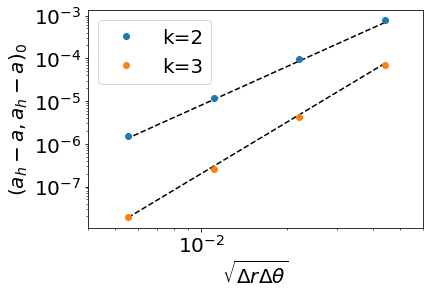

In [57]:
plt.rcParams.update({'font.size': 20})
abcissea = np.array([8e0, 20e0])

H = np.sqrt(Hx*Hy)

for j in range(cases_p):
    plt.loglog(H[:, j], abcissea[j]*H[:, j]**(j + 3), 'k--')
    
    plt.loglog(H[:, j], L2_error[:, j], 'o', label = 'k=' + str(j + 2))
    
    
plt.xlabel(r'$\sqrt{\Delta r\Delta \theta}$')
plt.ylabel('$(a_h - a, a_h - a)_0$')
plt.legend()
plt.xlim((4e-3, 6e-2))

plt.savefig('/home/florian/Desktop/PHD/04_Präsentationen/01_FEEC/01_Figures/0_form_convergence2.pdf', bbox_inches = 'tight')

In [28]:
Nxs = np.array([16, 32, 64, 128])
Nys = np.array([32, 64, 128, 256])

dxs = 1./Nxs
dys = 1./Nys

Hx = np.zeros((4, 2))
Hy = np.zeros((4, 2))

Hx[:, 0] = dxs
Hx[:, 1] = dxs

Hy[:, 0] = dys
Hy[:, 1] = dys

In [7]:
def assembly_v3(V, kernel):

    # ... sizes
    [s1, s2, s3] = V.vector_space.starts
    [e1, e2, e3] = V.vector_space.ends
    [p1, p2, p3] = V.vector_space.pads
    # ...

    # Quadrature data
    [      nk1,       nk2,       nk3] = [g.num_elements for g in V.quad_grids]
    [       k1,        k2,        k3] = [g.num_quad_pts for g in V.quad_grids]
    [  spans_1,   spans_2,   spans_3] = [g.spans        for g in V.quad_grids]
    [  basis_1,   basis_2,   basis_3] = [g.basis        for g in V.quad_grids]
    [ points_1,  points_2,  points_3] = [g.points       for g in V.quad_grids]
    [weights_1, weights_2, weights_3] = [g.weights      for g in V.quad_grids]

    # ... data structure
    M = StencilMatrix(V.vector_space, V.vector_space)
    # ...

    # ... element matrix
    mat = np.zeros((p1+1, p2+1, p3+1, 2*p1+1, 2*p2+1, 2*p3+1), order='F')
    # ...

    # ... build matrices
    for ie1 in range(s1, e1+1-p1):
        for ie2 in range(s2, e2+1-p2):
            for ie3 in range(s3, e3+1-p3):
                i_span_1 = spans_1[ie1]
                i_span_2 = spans_2[ie2]
                i_span_3 = spans_3[ie3]

                bs1 = basis_1[ie1, :, :, :]
                bs2 = basis_2[ie2, :, :, :]
                bs3 = basis_3[ie3, :, :, :]
                w1 = weights_1[ie1, :]
                w2 = weights_2[ie2, :]
                w3 = weights_3[ie3, :]
                kernel(p1, p2, p3, k1, k2, k3, bs1, bs2, bs3, w1, w2, w3, mat)

                s1 = i_span_1 - p1 - 1
                s2 = i_span_2 - p2 - 1
                s3 = i_span_3 - p3 - 1
                M._data[s1:s1+p1+1,s2:s2+p2+1,s3:s3+p3+1,:,:,:] += mat[:,:,:,:,:,:]

In [8]:
def kernel_3d(p1, p2, p3, k1, k2, k3, bs1, bs2, bs3, w1, w2, w3, mat):
    mat[:,:,:,:,:,:] = 0.
    for il_1 in range(0, p1+1):
        for jl_1 in range(0, p1+1):
            for il_2 in range(0, p2+1):
                for jl_2 in range(0, p2+1):
                    for il_3 in range(0, p3+1):
                        for jl_3 in range(0, p3+1):

                            v = 0.0
                            for g1 in range(0, k1):
                                for g2 in range(0, k2):
                                    for g3 in range(0, k3):
                                        bi_0 = bs1[il_1, 0, g1] * bs2[il_2, 0, g2] * bs3[il_3, 0, g3]
                                        bi_x = bs1[il_1, 1, g1] * bs2[il_2, 0, g2] * bs3[il_3, 0, g3]
                                        bi_y = bs1[il_1, 0, g1] * bs2[il_2, 1, g2] * bs3[il_3, 0, g3]
                                        bi_z = bs1[il_1, 0, g1] * bs2[il_2, 0, g2] * bs3[il_3, 1, g3]

                                        bj_0 = bs1[jl_1, 0, g1] * bs2[jl_2, 0, g2] * bs3[jl_3, 0, g3]
                                        bj_x = bs1[jl_1, 1, g1] * bs2[jl_2, 0, g2] * bs3[jl_3, 0, g3]
                                        bj_y = bs1[jl_1, 0, g1] * bs2[jl_2, 1, g2] * bs3[jl_3, 0, g3]
                                        bj_z = bs1[jl_1, 0, g1] * bs2[jl_2, 0, g2] * bs3[jl_3, 1, g3]

                                        wvol = w1[g1] * w2[g2] * w3[g3]

                                        v += (bi_x * bj_x + bi_y * bj_y + bi_z * bj_z) * wvol
                            mat[il_1, il_2, il_3, p1 + jl_1 - il_1, p2 + jl_2 - il_2, p3 + jl_3 - il_3] = v

In [9]:
from psydac.linalg.stencil import StencilMatrix, StencilVector

# ... numbers of elements and degres
p1  = 3 ; p2  = 3 ; p3  = 3
ne1 = 16 ; ne2 = 16 ; ne3 = 16
# ...

print('> Grid   :: [{},{},{}]'.format(ne1, ne2, ne3))
print('> Degree :: [{},{},{}]'.format(p1, p2, p3))

grid_1 = np.linspace(0., 1., ne1+1)
grid_2 = np.linspace(0., 1., ne2+1)
grid_3 = np.linspace(0., 1., ne3+1)

V1 = ps.fem.splines.SplineSpace(p1, grid=grid_1)
V2 = ps.fem.splines.SplineSpace(p2, grid=grid_2)
V3 = ps.fem.splines.SplineSpace(p3, grid=grid_3)

V = ps.fem.tensor.TensorFemSpace(V1, V2, V3)

> Grid   :: [16,16,16]
> Degree :: [3,3,3]


In [10]:
print('-- elapsed times --')

# ... pure python version 3 (kernel_3 = kernel_2)
tb = time.time()
assembly_v3(V, kernel_3d)
te = time.time()
print('> {} [pure Python v3]'.format(te-tb))
# ...

-- elapsed times --


ValueError: operands could not be broadcast together with shapes (0,0,0,7,7,7) (4,4,4,7,7,7) (0,0,0,7,7,7) 

In [11]:
# ... sizes
[s1, s2, s3] = V.vector_space.starts
[e1, e2, e3] = V.vector_space.ends
[p1, p2, p3] = V.vector_space.pads
# ...

# Quadrature data
[      nk1,       nk2,       nk3] = [g.num_elements for g in V.quad_grids]
[       k1,        k2,        k3] = [g.num_quad_pts for g in V.quad_grids]
[  spans_1,   spans_2,   spans_3] = [g.spans        for g in V.quad_grids]
[  basis_1,   basis_2,   basis_3] = [g.basis        for g in V.quad_grids]
[ points_1,  points_2,  points_3] = [g.points       for g in V.quad_grids]
[weights_1, weights_2, weights_3] = [g.weights      for g in V.quad_grids]

In [12]:
M = StencilMatrix(V.vector_space, V.vector_space)

# ... element matrix
mat = np.zeros((p1+1, p2+1, p3+1, 2*p1+1, 2*p2+1, 2*p3+1), order='F')
# ...

# ... build matrices
for ie1 in range(s1, e1+1-p1):
    for ie2 in range(s2, e2+1-p2):
        for ie3 in range(s3, e3+1-p3):
            i_span_1 = spans_1[ie1]
            i_span_2 = spans_2[ie2]
            i_span_3 = spans_3[ie3]

            bs1 = basis_1[ie1, :, :, :]
            bs2 = basis_2[ie2, :, :, :]
            bs3 = basis_3[ie3, :, :, :]
            w1 = weights_1[ie1, :]
            w2 = weights_2[ie2, :]
            w3 = weights_3[ie3, :]
            kernel_3d(p1, p2, p3, k1, k2, k3, bs1, bs2, bs3, w1, w2, w3, mat)

            s1 = i_span_1 - p1 - 1
            s2 = i_span_2 - p2 - 1
            s3 = i_span_3 - p3 - 1
            
            M[i_span_1 - p1:i_span_1 + 1, i_span_2 - p2:i_span_2 + 1, i_span_3 - p3:i_span_3 + 1, :, :, :] += mat[:, :, :, :, :, :]

KeyboardInterrupt: 

In [13]:
M._data[s1:s1+p1+1,s2:s2+p2+1,s3:s3+p3+1,:,:,:]

array([], shape=(0, 0, 4, 7, 7, 7), dtype=float64)

In [64]:
mat.shape

(4, 4, 4, 7, 7, 7)

In [67]:
M0[0,0,0,:,:,:].shape

(5, 5, 5)